# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


# Defining the functions(GENERAL)

## Parameter initialization

In [5]:
def params_init(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [6]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [7]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
  return loss

## Forward pass

In [8]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [9]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [10]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [11]:
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [18]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,5, 0.1, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 74.06666666666666
Val accuracy: 74.04285714285714
Iteration: 2
Train accuracy: 81.43333333333334
Val accuracy: 81.6
Iteration: 3
Train accuracy: 84.46825396825398
Val accuracy: 84.62857142857143
Iteration: 4
Train accuracy: 86.27460317460317
Val accuracy: 86.24285714285715
Iteration: 5
Train accuracy: 87.45396825396826
Val accuracy: 87.2


# Weight perturbation

In [13]:
def WP(W1, b1, W2, b2, pert, lossBeforePert, X, y):
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1pert, b1, W2, b2)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1pert, W2, b2)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1, b1, W2pert, b2)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1, W2, b2pert)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [14]:
def batch_grad_descentWP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [17]:
pertList = [0.1, 0.01, 0.001, 0.0001]
trainAccWP = []
valAccWP = []
for pert in pertList:
    _, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descentWP(x_train,y_train,5, 0.1, pert = pert, print_op=1);
    trainAccWP.append(train_acc)
    valAccWP.append(val_acc)

Params Initialised
Iteration: 1 sub iter 99 : 74.285714285714295
Train accuracy: 73.65396825396824
Val accuracy: 73.55714285714285
Iteration: 2 sub iter 99 : 81.74603174603175
Train accuracy: 80.5063492063492
Val accuracy: 80.54285714285714
Iteration: 3 sub iter 99 : 84.76190476190476
Train accuracy: 83.32063492063492
Val accuracy: 83.35714285714285
Iteration: 4 sub iter 99 : 86.03174603174604
Train accuracy: 84.85079365079365
Val accuracy: 84.55714285714285
Iteration: 5 sub iter 99 : 86.66666666666667
Train accuracy: 85.74126984126984
Val accuracy: 85.5
Params Initialised
Iteration: 1 sub iter 99 : 75.079365079365085
Train accuracy: 74.01269841269841
Val accuracy: 74.0
Iteration: 2 sub iter 99 : 80.95238095238095
Train accuracy: 81.35396825396826
Val accuracy: 81.5
Iteration: 3 sub iter 99 : 84.76190476190476
Train accuracy: 84.42222222222222
Val accuracy: 84.42857142857143
Iteration: 4 sub iter 99 : 86.50793650793657
Train accuracy: 86.2
Val accuracy: 86.1
Iteration: 5 sub iter 99 : 

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

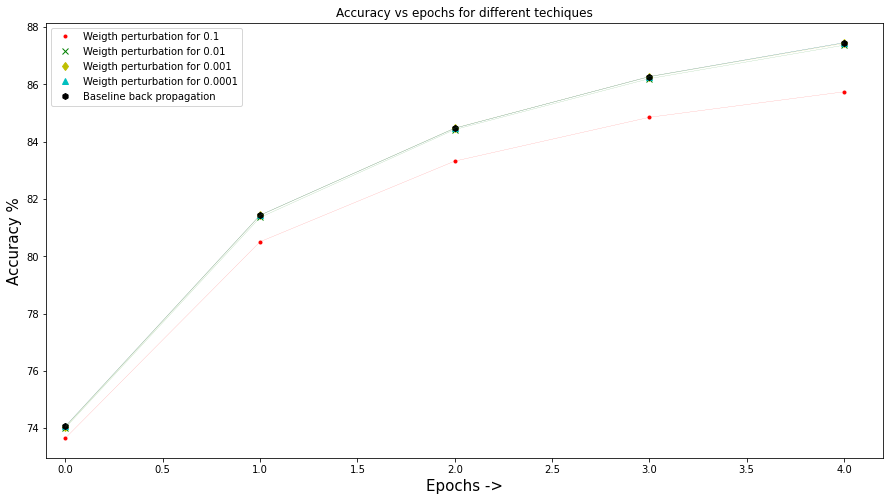

In [34]:
plt.figure(figsize=(15, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i for i in range(5)]
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], format[_])
    leg.append(f"Weigth perturbation for {pertList[_]}")
plt.plot(epochList, train_accBP, 'kh')
leg.append("Baseline back propagation")
for _ in range(len(pertList)):
    plt.plot(epochList, trainAccWP[_], col[_], linewidth=0.2, alpha = 0.5)
plt.plot(epochList, train_accBP, 'k', linewidth=0.2, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = -0.1)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")

Text(0.5, 1.0, 'Accuracy vs epochs for different techiques')

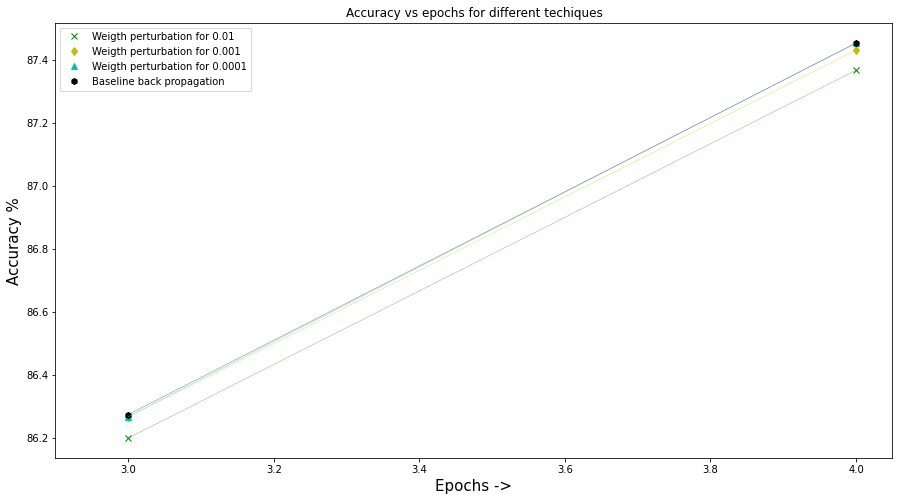

In [37]:
plt.figure(figsize=(15, 8))
format = ['r.', 'gx', 'yd', 'c^']
col = ['r', 'g', 'y', 'c']
leg = []
epochList = [i for i in range(5)]
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], format[_])
    leg.append(f"Weigth perturbation for {pertList[_]}")
plt.plot(epochList[3:], train_accBP[3:], 'kh')
leg.append("Baseline back propagation")
for _ in range(1, len(pertList)):
    plt.plot(epochList[3:], trainAccWP[_][3:], col[_], linewidth=0.5, alpha = 0.5)
plt.plot(epochList[3:], train_accBP[3:], 'k', linewidth=0.5, alpha = 0.5)
plt.legend(leg)
plt.xlim(left = 2.9)
plt.xlabel("Epochs ->", size = 15)
plt.ylabel("Accuracy %", size = 15)
plt.title("Accuracy vs epochs for different techiques")